<a href="https://colab.research.google.com/github/covidba/covid/blob/master/covid19_vitoria_da_conquista.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evolução da COVID-19 em Vitória da Conquista/BA
**Fonte**: https://www.pmvc.ba.gov.br/  
**Dados crus**: https://raw.githubusercontent.com/covidba/covid/master/vitoria_da_conquista.csv   
**Github**: https://github.com/covidba/covid

In [0]:
import sys
from google.colab import drive
drive.mount('/content/gdrive')
 
!cd gdrive/My\ Drive && git clone https://github.com/ramonfontes/Mathematical-and-Statistical-Modeling-of-COVID19-in-Brazil/ model
!pip install platypus-opt
!pip install pyswarms==1.1.0

#add the path were the models are
sys.path.append("/content/gdrive/My Drive/model/main/")

from modelos import SIR

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
fatal: destination path 'model' already exists and is not an empty directory.
     |████████████████████████████████| 71kB 1.9MB/s 
     |████████████████████████████████| 102kB 2.5MB/s 


In [0]:
from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import pandas as pd
import numpy as np

cidade = 'Vitória da Conquista'
cidade_file_name = 'vitoria_da_conquista'
populacao = 338480

data_atual = date.today().strftime("%d-%m-%Y")
url = 'https://raw.githubusercontent.com/covidba/covid/master/%s.csv' % cidade_file_name
df = pd.read_csv(url, usecols=['data', 'confirmados','recuperados', 'mortes_residencia', 'mortes_ocorrencia', 'restricao']) #, parse_dates=['data'])
df.columns = ['data', 'Casos confirmados', 'Casos recuperados', 'Mortes residência', 'Mortes ocorrência', 'Medida restritiva']
df['data'] = pd.to_datetime(df['data'])

In [0]:
#Start the model with population size
model = SIR(tamanhoPop = populacao)
#create a series with the cummulative number of cases
y = df["Casos confirmados"]
#Give the number of days since the day of first case confirmed
x = range(1,len(df["Casos confirmados"]) + 1)
model.fit(x = x, y = y)
#Predict the number of cases
df["Expectativa"] = model.predict(x)

2020-06-02 15:11:05,866 - pyswarms.single.local_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 3, 'p': 1}
pyswarms.single.local_best:   0%|          |0/500/content/gdrive/My Drive/model/main/modelos.py:156: RuntimeWarning: overflow encountered in exp
  h = 1.0/(1.0+ np.exp(-2.0*50*t))
pyswarms.single.local_best: 100%|██████████|500/500, best_cost=1.47
2020-06-02 15:13:01,730 - pyswarms.single.local_best - INFO - Optimization finished | best cost: 1.4729827477938935, best pos: [ 0.32470051  0.15310649  0.18206209 10.22655422]


In [0]:
#Projections about the future
futherCases = pd.DataFrame.from_dict({"data":pd.date_range(start = df['data'].max()+timedelta(days=1) , end = df['data'].max()+timedelta(days=7))})

df_proj = pd.concat([df,futherCases])
#create the new series to be predicted
predictions = model.predict(df_proj)
new_df = df.append(futherCases)
new_df.reset_index(inplace=True, drop=True)
new_df['Expectativa'] = predictions

/content/gdrive/My Drive/model/main/modelos.py:156: RuntimeWarning: overflow encountered in exp
  h = 1.0/(1.0+ np.exp(-2.0*50*t))


2020-06-02 15:13:09,400 - numexpr.utils - INFO - NumExpr defaulting to 2 threads.


,data,Casos confirmados,Casos recuperados,Mortes residência,Mortes ocorrência,Medida restritiva,Expectativa,Casos ativos,Casos ativos (%)
43,2020-05-13,58,37,4,NaN,NaN,67.716666,21,36.2
44,2020-05-14,58,37,4,NaN,NaN,70.478364,21,36.2
45,2020-05-15,63,37,4,NaN,NaN,73.320794,26,41.3
46,2020-05-16,74,40,4,NaN,NaN,76.246588,34,45.9
47,2020-05-17,75,44,4,NaN,NaN,79.258151,31,41.3
48,2020-05-18,83,47,4,NaN,NaN,82.357981,36,43.4
49,2020-05-19,95,47,4,NaN,NaN,85.548668,48,50.5
50,2020-05-20,97,51,4,NaN,NaN,88.832894,46,47.4
51,2020-05-21,97,51,4,NaN,NaN,92.213431,46,47.4
52,2020-05-22,106,57,4,NaN,NaN,95.693131,49,46.2


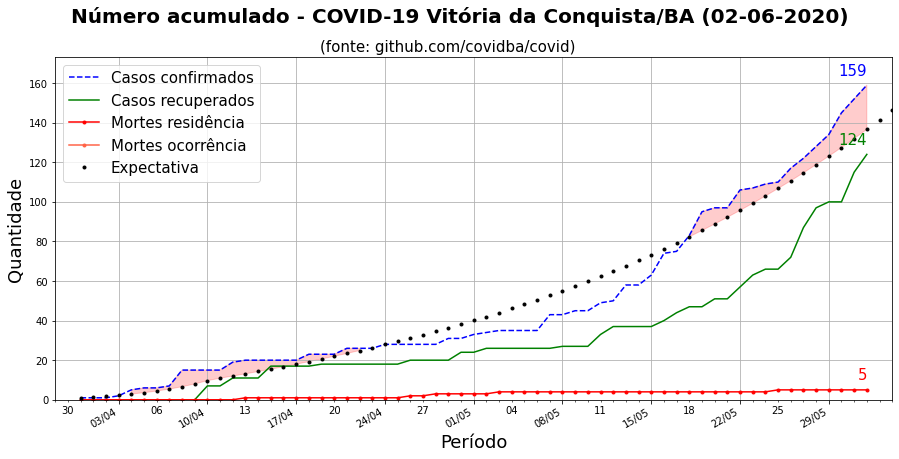

In [0]:
from matplotlib.dates import MO

casos_ativos_diaria = []
for i, v in enumerate(df['Casos confirmados']):
  casos_ativos_diaria.append(v - df['Casos recuperados'][i])
df['Casos ativos'] = casos_ativos_diaria

percentual_casos_ativos_diaria = []
for i, v in enumerate(df['Casos confirmados']):
  percentual_casos_ativos_diaria.append('%.1f' % (df['Casos ativos'][i]*100/v))
df['Casos ativos (%)'] = percentual_casos_ativos_diaria

new_df = df.append(futherCases)
new_df.reset_index(inplace=True, drop=True)
new_df['Expectativa'] = predictions

#set date as index
lista_data = new_df['data']
new_df.set_index('data', inplace=True)

fig, ax = plt.subplots(figsize=(15,7))
colors = ['b','g','r', 'tomato', 'black']
ls = ['--', '-', '.-', '.-', '.']

df2 = new_df
del df2['Casos ativos']
del df2['Medida restritiva']
df2.plot(ax=ax, color=colors, style=ls)
fig.autofmt_xdate()

#set ticks every week
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(MO))
#plt.gca().xaxis.set_major_formatter(plt.FixedFormatter(df.index.to_series().dt.strftime("%d/%m")))

ax.tick_params(axis="x", labelsize=10)
ax.tick_params(axis="y", labelsize=10)
ax.set_xticks(ax.get_xticks()[::1])
ax.legend(prop=dict(size=15))

# ADICIONAR VALORES
casos_confirmados_series = pd.DataFrame(df2['Casos confirmados'])
ultimo_caso_valido_id = casos_confirmados_series.index.get_loc(casos_confirmados_series.last_valid_index())
def adicionar_valores(caso, color, y=10):
  ax.annotate(int(df2[caso].max()), xy=(lista_data[ultimo_caso_valido_id], df2[caso].max()), 
              xycoords='data', ha='right', fontsize=15, color=color,
              xytext=(0, y), textcoords='offset points')
  
adicionar_valores('Casos confirmados', 'b')
adicionar_valores('Casos recuperados', 'g')
adicionar_valores('Mortes residência', 'r')
#adicionar_valores('Mortes ocorrência', 'black', -20)
#adicionar_valores('Mortes', 'r')

casos_ativos = int(df2['Casos confirmados'].max() - df2['Casos recuperados'].max())
#taxa_mortalidade = (100 * df2['Mortes'].max()) / df2['Casos confirmados'].max()
url_fonte = 'github.com/covidba/covid'

ax.fill_between(new_df.index, new_df['Casos confirmados'], new_df['Expectativa'], 
                where=new_df['Casos confirmados']>=new_df['Expectativa'], alpha=0.2, color='red')

ax.set_ylim(0, new_df['Expectativa'].max())
ax.set_xlim([lista_data.min()-timedelta(days=2), lista_data.max()-timedelta(days=5)])
fig.suptitle("Número acumulado - COVID-19 %s/BA (%s)" % (cidade, data_atual), fontsize=20,  fontweight='bold')
ax.set_title("(fonte: %s)           " % url_fonte, fontsize=15)
ax.set_ylabel('Quantidade', fontsize=18)
ax.set_xlabel('Período', fontsize=18)
ax.grid(True)
df.tail(20)

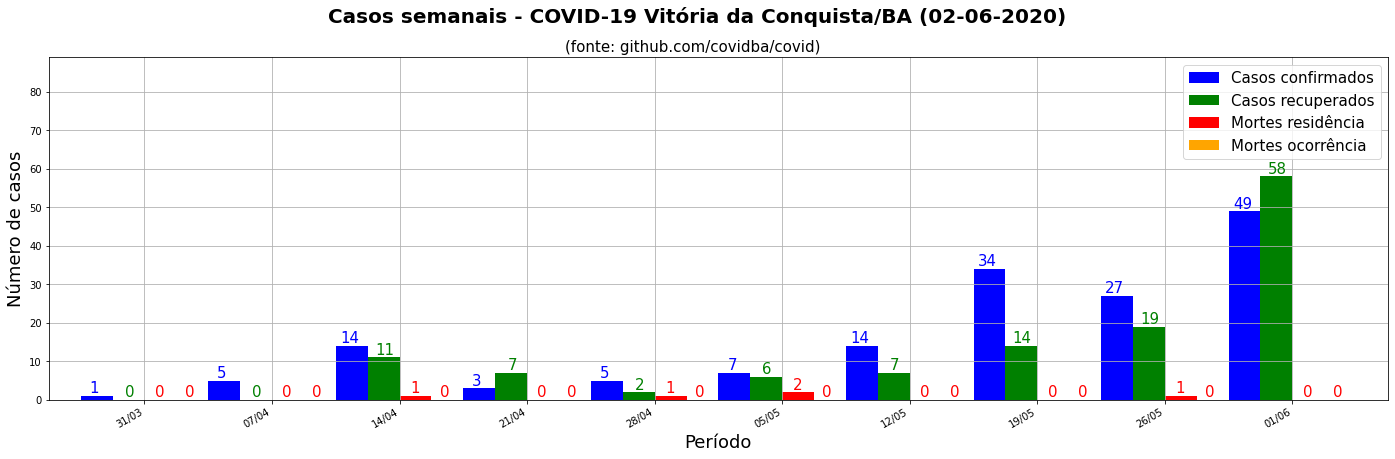

In [0]:
frequencia = 7
colors = ['b','g','r', 'orange']

dict_diaria = dict()
dict_diaria['data'] = []
dict_diaria['confirmados_diaria'] = []
dict_diaria['recuperados_diaria'] = []
dict_diaria['mortes_diaria_residencia'] = []
dict_diaria['mortes_diaria_ocorrencia'] = []

casos_confirmados_diaria = []
casos_recuperados_diaria = []
casos_mortes_diaria_residencia = []
casos_mortes_diaria_ocorrencia = []

def alimentar_lista(lista, texto):
  for id, v in enumerate(new_df[texto]):
    if not pd.isnull(v):
      primeiro_caso_series = pd.DataFrame(df2[texto])
      primeiro_caso_valido_id = primeiro_caso_series.index.get_loc(primeiro_caso_series.first_valid_index())
      if(id) == 0 or id == primeiro_caso_valido_id:
        lista.append(v)  
      else:
        lista.append(v - new_df[texto][id-1])
    elif id < len(lista_data)-7:
      lista.append(0)

alimentar_lista(casos_confirmados_diaria, 'Casos confirmados')
alimentar_lista(casos_recuperados_diaria, 'Casos recuperados')
alimentar_lista(casos_mortes_diaria_residencia, 'Mortes residência')
alimentar_lista(casos_mortes_diaria_ocorrencia, 'Mortes ocorrência')

def alimentar_dict(lista, texto):
  soma_casos = 0
  for id, v in enumerate(lista):
    if not pd.isnull(v):
      if id % frequencia == 0:
        if texto == 'confirmados_diaria':
            dict_diaria['data'].append(lista_data[id])
        if id == 0:
          dict_diaria[texto].append(v)
        else:
          dict_diaria[texto].append(soma_casos)
          soma_casos = v
      else:
        soma_casos += v     
        if(len(lista)-1 == id):
          dict_diaria[texto].append(soma_casos)
          if texto == 'confirmados_diaria':
            dict_diaria['data'].append(lista_data[id])

alimentar_dict(casos_confirmados_diaria, 'confirmados_diaria')
alimentar_dict(casos_recuperados_diaria, 'recuperados_diaria')
alimentar_dict(casos_mortes_diaria_residencia, 'mortes_diaria_residencia')
alimentar_dict(casos_mortes_diaria_ocorrencia, 'mortes_diaria_ocorrencia')

df_diaria = pd.DataFrame(dict_diaria)
df_diaria.columns = ['data', 'Casos confirmados', 'Casos recuperados', 'Mortes residência', 'Mortes ocorrência']
novo_df = df_diaria

df_diaria.set_index('data', inplace=True)
fig, ax = plt.subplots(figsize=(24,7))
df_diaria.plot(ax=ax, color=colors, kind='bar', width=1)
fig.autofmt_xdate()

# workaround para erro em bar kind
plt.gca().xaxis.set_major_formatter(plt.FixedFormatter(df_diaria.index.to_series().dt.strftime("%d/%m")))

ax.tick_params(axis="x", labelsize=10)
ax.tick_params(axis="y", labelsize=10)
ax.set_xticks(ax.get_xticks()[::1])
ax.legend(prop=dict(size=15))

def plotar_valores(texto, cor, x):
  for i, v in enumerate(df_diaria[texto]):
    if not pd.isnull(v):
      ax.annotate(int(v), xy=(i, v), xycoords='data', ha='center', fontsize=15, color=cor,
                xytext=(x, 3), textcoords='offset points')

plotar_valores('Casos confirmados', 'b', -50)
plotar_valores('Casos recuperados', 'g', -15)
plotar_valores('Mortes residência', 'r', 15)
plotar_valores('Mortes ocorrência', 'r', 45)
#plotar_valores('Casos ativos', 'orange', 26)

ax.set_ylim([0, df_diaria['Casos confirmados'].max() + 40])
fig.suptitle("Casos semanais - COVID-19 %s/BA (%s)" % (cidade, data_atual), fontsize=20, fontweight='bold')
ax.set_title("(fonte: %s)           " % url_fonte, fontsize=15)
ax.set_ylabel('Número de casos', fontsize=18)
ax.set_xlabel('Período', fontsize=18)
ax.grid(True)

plt.savefig('/content/gdrive/My Drive/model/%s-barras.png' % cidade_file_name)

0    2020-03-31
1    2020-04-01
2    2020-04-02
3    2020-04-03
4    2020-04-04
        ...    
65   2020-06-04
66   2020-06-05
67   2020-06-06
68   2020-06-07
69   2020-06-08
Name: data, Length: 70, dtype: datetime64[ns]


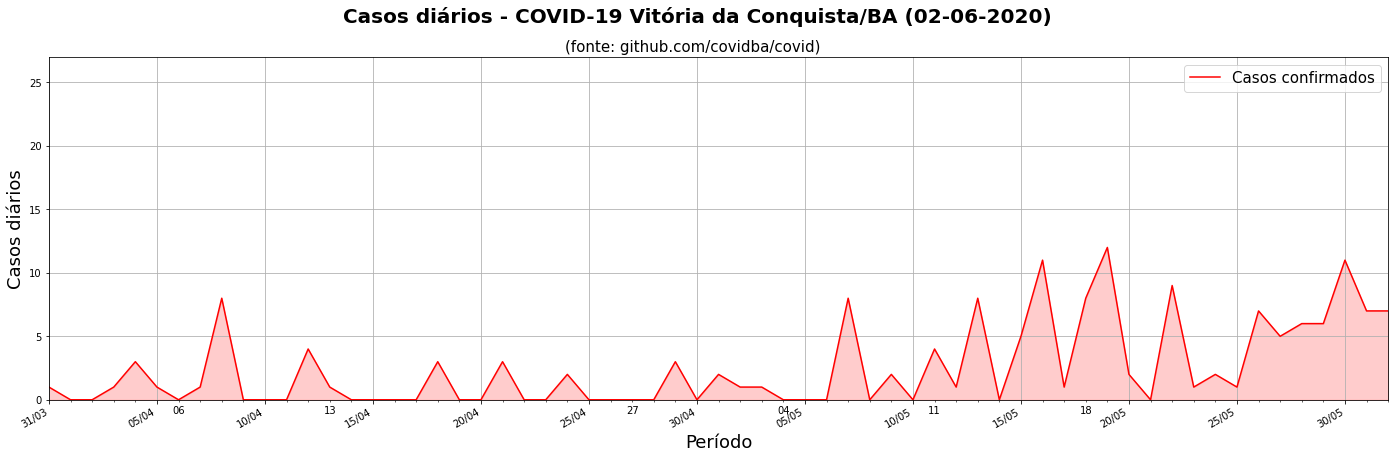

In [0]:
dict_diaria = dict()
dict_diaria['data'] = lista_data[:len(lista_data)-7]
dict_diaria['confirmados_diaria'] = casos_confirmados_diaria

df_diaria = pd.DataFrame(dict_diaria)
df_diaria.columns = ['data', 'Casos confirmados']
novo_df = df_diaria

print(lista_data)
df_diaria.set_index('data', inplace=True)
fig, ax = plt.subplots(figsize=(24,7))
df_diaria.plot(ax=ax, color='r', kind='line')
fig.autofmt_xdate()

ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(MO))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))

ax.tick_params(axis="x", labelsize=10)
ax.tick_params(axis="y", labelsize=10)
ax.set_xticks(ax.get_xticks()[::1])
ax.legend(prop=dict(size=15))

ax.fill_between(df_diaria.index, 0, df_diaria['Casos confirmados'], alpha=0.2, color='red')

ax.set_ylim([0, df_diaria['Casos confirmados'].max()+15])
ax.set_xlim([lista_data.min(), lista_data.max()-timedelta(days=7)])
fig.suptitle("Casos diários - COVID-19 %s/BA (%s)" % (cidade, data_atual), fontsize=20, fontweight='bold')
ax.set_title("(fonte: %s)           " % url_fonte, fontsize=15)
ax.set_ylabel('Casos diários', fontsize=18)
ax.set_xlabel('Período', fontsize=18)
ax.grid(True)

plt.savefig('/content/gdrive/My Drive/model/%s-evolucao-diaria.png' % cidade_file_name)

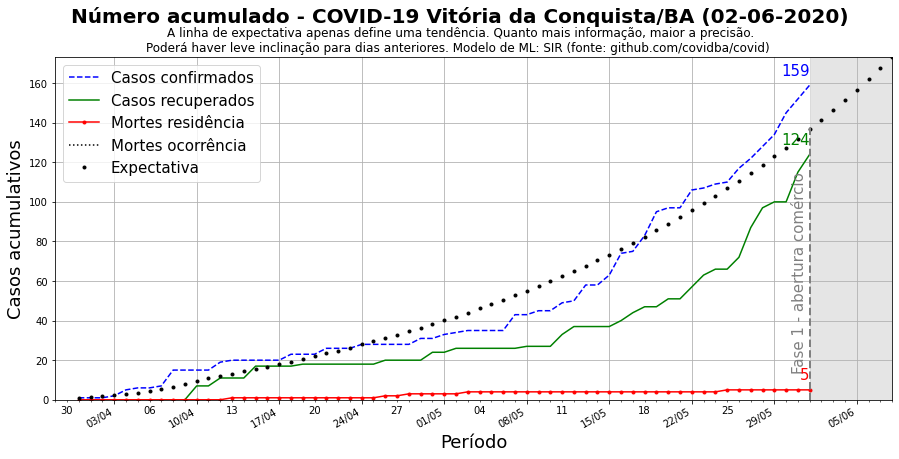

In [0]:
fig, ax = plt.subplots(figsize=(15,7))
colors = ['b','g','r', 'black', 'black']
ls = ['--', '-', '.-', ':', '.']
new_df1 = new_df
if 'Casos ativos' in new_df1:
  del new_df1['Casos ativos']
if 'Medida restritiva' in new_df1:
  del new_df1['Medida restritiva']
new_df1.plot(ax=ax, color=colors, style=ls)
fig.autofmt_xdate()

#set ticks every week
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(MO))

ax.tick_params(axis="x", labelsize=10)
ax.tick_params(axis="y", labelsize=10)
ax.set_xticks(ax.get_xticks()[::1])
ax.legend(prop=dict(size=15))

# pintar área de projeção
ax.axvspan(df['data'][ultimo_caso_valido_id].strftime("%Y-%m-%d"), lista_data.max().strftime("%Y-%m-%d"), 
           alpha=0.2, color='gray')

def adicionar_medida(texto, id, color='green'):
  ax.axvline(linewidth=2, color=color, ls='--', x=lista_data[(lista_data == pd.Timestamp(df['data'][id])).argmax()], ymax=0.8)
  ax.annotate('%s' % texto, xy=(lista_data[(lista_data == pd.Timestamp(df['data'][id])).argmax()], new_df1['Mortes residência'].max()+10), rotation=90,
            xycoords='data', ha='center', fontsize=15, color=color,
            xytext=(-10, 0), textcoords='offset points')

# ADICIONAR MEDIDAS
def adicionar_medidas():
  for id, medida in enumerate(df['Medida restritiva']):
    # toque de recolher
    if not pd.isnull(medida):
      if medida == 0:
        adicionar_medida('Abertura comércio', id) 
      elif medida == 1:
        adicionar_medida('Fechamento comércio', id, color='purple') 
      elif medida > 1 and medida <= 24:
        if medida == 24:
          adicionar_medida('Saída do toque de recolher', id)
        else:
          adicionar_medida('Toque de recolher (%sh)' % int(medida), id, color='purple')      
      elif medida == 50:
        adicionar_medida('Entrada no lockdown', id, color='purple')
      elif medida == 51:
        adicionar_medida('Saída do lockdown', id)
      elif medida == 61:
        adicionar_medida('Fase 1 - abertura comércio', id, color='gray')
      elif medida == 62:
        adicionar_medida('Fase 2 - abertura comércio', id, color='gray')
      elif medida == 63:
        adicionar_medida('Fase 3 - abertura comércio', id, color='gray')
      elif medida == 64:
        adicionar_medida('Fase 4 - abertura comércio', id, color='gray')
      elif medida == 65:
        adicionar_medida('Fase 5 - abertura comércio', id, color='gray')
  
adicionar_medidas()

# ADICIONAR VALORES  
adicionar_valores('Casos confirmados', 'b')
adicionar_valores('Casos recuperados', 'g')
adicionar_valores('Mortes residência', 'r')
#adicionar_valores('Mortes ocorrência', 'black', -20)

ax.set_xlim([lista_data.min()-timedelta(days=2), lista_data.max()])
ax.set_ylim([0, new_df1['Expectativa'].max()])
fig.suptitle("Número acumulado - COVID-19 %s/BA (%s)" % (cidade, data_atual), fontsize=20, fontweight='bold')
ax.set_title("A linha de expectativa apenas define uma tendência. Quanto mais informação, maior a precisão.       \nPoderá haver leve inclinação para dias anteriores. Modelo de ML: SIR (fonte: %s)        "  % url_fonte)
ax.set_ylabel('Casos acumulativos', fontsize=18)
ax.set_xlabel('Período', fontsize=18)
ax.grid(True)
plt.savefig('/content/gdrive/My Drive/model/%s-todo.png' % cidade_file_name)

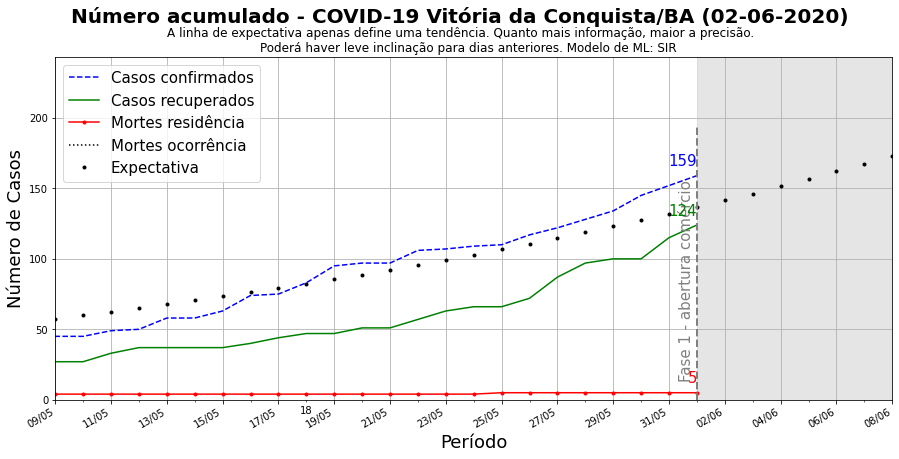

In [22]:
fig, ax = plt.subplots(figsize=(15,7))
colors = ['b','g','r', 'black', 'black']
ls = ['--', '-', '.-', ':', '.']
new_df.plot(ax=ax, color=colors, style=ls)
fig.autofmt_xdate()

#set ticks every week
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(MO))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))

ax.tick_params(axis="x", labelsize=10)
ax.tick_params(axis="y", labelsize=10)
ax.set_xticks(ax.get_xticks()[::1])
ax.legend(prop=dict(size=15))

# pintar área de projeção
ax.axvspan(df['data'][ultimo_caso_valido_id].strftime("%Y-%m-%d"), lista_data.max().strftime("%Y-%m-%d"), 
           alpha=0.2, color='gray')

adicionar_medidas()

# ADICIONAR VALORES
adicionar_valores('Casos confirmados', 'b')
adicionar_valores('Casos recuperados', 'g')
adicionar_valores('Mortes residência', 'r')

ax.set_ylim([0, new_df['Expectativa'].max() + 70])
ax.set_xlim([lista_data.max() - timedelta(days=30), lista_data.max()])
fig.suptitle("Número acumulado - COVID-19 %s/BA (%s)" % (cidade, data_atual), fontsize=20, fontweight='bold')
ax.set_title("A linha de expectativa apenas define uma tendência. Quanto mais informação, maior a precisão.       \nPoderá haver leve inclinação para dias anteriores. Modelo de ML: SIR   ")
ax.set_ylabel('Número de Casos', fontsize=18)
ax.set_xlabel('Período', fontsize=18)
ax.grid(True)
plt.savefig('/content/gdrive/My Drive/model/vitoria_da_conquista-30-dias.png')